In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from sklearn.externals import joblib

from utility import *
from lane_fitting import *
import os.path as path
from moviepy.editor import VideoFileClip

%matplotlib inline

# Camera calibration
Calibrate camera using opencv library and test the result.

In [3]:
calibration_file_dir = './camera_cal/'
mtx_path = './mtx.pkl'
dist_path = './dist.pkl'

In [4]:
if path.isfile(mtx_path) and path.isfile(dist_path):
    mtx = joblib.load('./mtx.pkl')
    dist = joblib.load('./dist.pkl')
else:
    mtx, dist = calibrate_from_dir(calibration_file_dir, mtx_path, dist_path)

## visualize undistortion process with checkboard image.

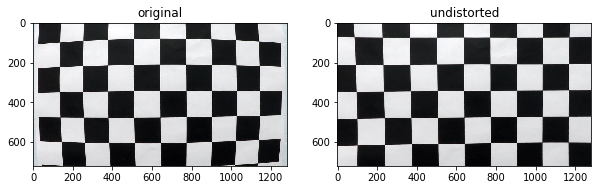

In [5]:
img = cv2.imread(calibration_file_dir+'calibration1.jpg')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(img)
ax1.set_title('original')
dst = cv2.undistort(img, mtx, dist, None, mtx)
ax2.set_title('undistorted')
ax2.imshow(dst)

# Perspective transform
Get bird's view of the road from camera image

In [11]:
img_list = sorted(glob.glob('./test_images/*.jpg'))
img_index = 7

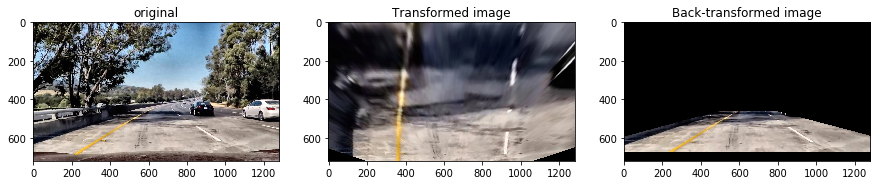

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 30))

img = cv2.imread(img_list[img_index])
#img = remove_shadow(img)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('original')

M, warped = get_birdview(img)
ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Transformed image')

Minv = np.linalg.inv(M)
warpedback = cv2.warpPerspective(warped, Minv, 
                                 dsize=warped.shape[1::-1])
ax3.imshow(cv2.cvtColor(warpedback, cv2.COLOR_BGR2RGB))
ax3.set_title('Back-transformed image')

# Binarize image by sobel operator and color thresholding

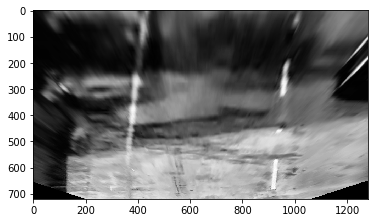

In [14]:
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, 'gray')

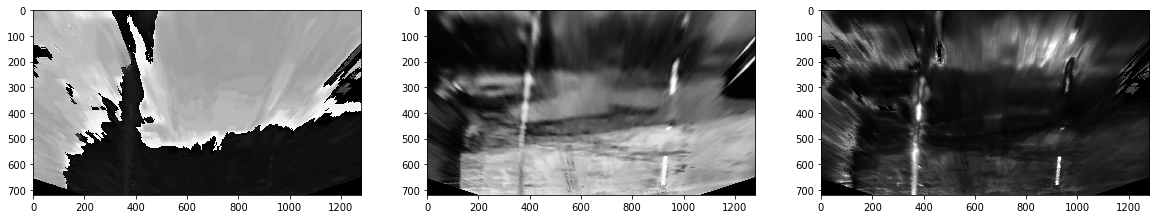

In [15]:
hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
figure, ax = plt.subplots(1,3, figsize=(20, 30))
for i in range(3):
    ax[i].imshow(hls[..., i], 'gray')

## Add color masks to add robustness to handle challenge movies

194804


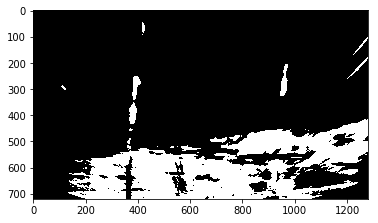

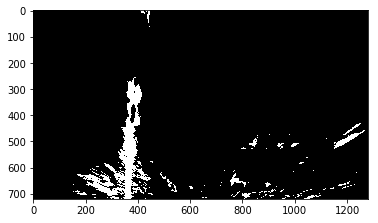

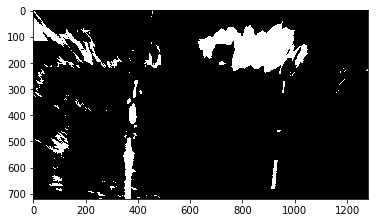

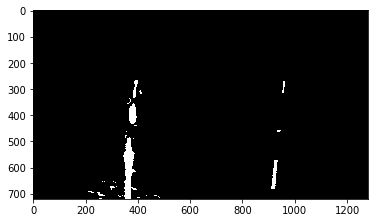

In [16]:
plt.figure()
white = white_mask(hls, sensitivity=85)
plt.imshow(white, 'gray')

plt.figure()
yellow = yellow_mask(hls)
plt.imshow(yellow, 'gray')

plt.figure()
chan_mask = np.zeros_like(yellow)
chan_mask[hls[..., 2] > 100] = 1
plt.imshow(chan_mask, 'gray')

plt.figure()
color_mask = cv2.bitwise_or(white, yellow)
print (np.sum(color_mask))
if np.sum(color_mask) > 40000:
    color_mask = cv2.bitwise_and(color_mask, chan_mask)
color_mask[:, :200] = 0
color_mask[:, 1150:] = 0
plt.imshow(color_mask, 'gray')

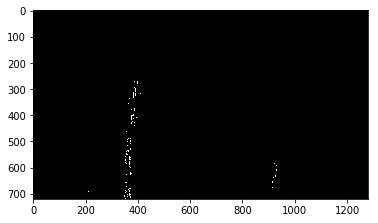

In [17]:
sobel = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(15, 25))
#sobel = mag_thresh(gray, thresh=(15, 25))
combined = np.zeros_like(sobel)
combined[(sobel == 1) & (color_mask == 1)] = 1
plt.imshow(combined, 'gray')

In [2]:
def binary_mask(gray, hls):
    white = white_mask(hls, sensitivity=85)
    yellow = yellow_mask(hls)
    chan_mask = np.zeros_like(yellow)
    chan_mask[hls[..., 2] > 100] = 1
    color_mask = cv2.bitwise_or(white, yellow)
    if np.sum(color_mask) > 40000:
        color_mask = cv2.bitwise_and(color_mask, chan_mask)
    color_mask[:, :200] = 0
    color_mask[:, 1150:] = 0
    sobel = mag_thresh(gray, thresh=(0, 255))
    combined = np.zeros_like(sobel)
    combined[(sobel == 1) & (color_mask == 1)] = 1
    return combined

# Sliding window search and polynomial fitting

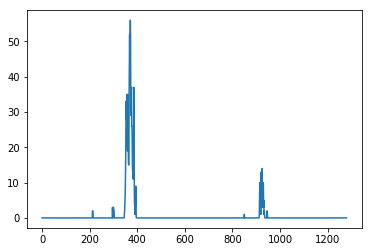

In [19]:
img = combined
histogram = np.sum(img[img.shape[0]//2:, ...], axis=0)
plt.plot(histogram)

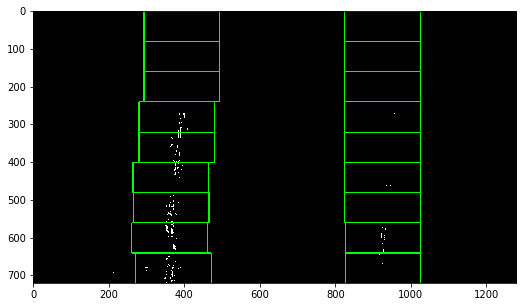

In [20]:
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

left_ys, left_xs, out = sliding_window(img, leftx_base)
right_ys, right_xs, out = sliding_window(img, rightx_base, out_img=out)
fig = plt.figure(figsize=(10,5))
plt.imshow(out)

In [21]:
# Fit a second order polynomial to each
left_fit = np.polyfit(left_ys, left_xs, 2)
right_fit = np.polyfit(right_ys, right_xs, 2)
loff = left_fit[2]
roff = right_fit[2]

In [22]:
print(left_fit)
print(right_fit)

[  2.23032423e-04  -2.94392404e-01   4.59929564e+02]
[ -6.62347359e-05  -4.18481228e-02   9.74313188e+02]


(720, 0)

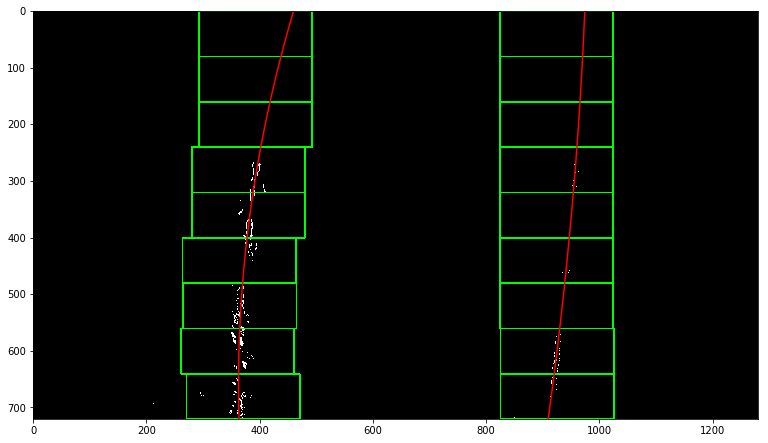

In [23]:
# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

fig = plt.figure(figsize=(15,7.5))
plt.imshow(out)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Calculate curvature for both lanes

In [24]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/520 # meters per pixel in x dimension

y_eval = 720
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(left_ys*ym_per_pix, left_xs*xm_per_pix, 2)
right_fit_cr = np.polyfit(right_ys*ym_per_pix, right_xs*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

547.009359238 m 1843.40590464 m


Calculate relative car position to lane center

In [25]:
d = car_position_offset(img.shape, left_fit, right_fit, xm_per_pix)
print(d)

-0.0233616094176


Visualize lane fitting

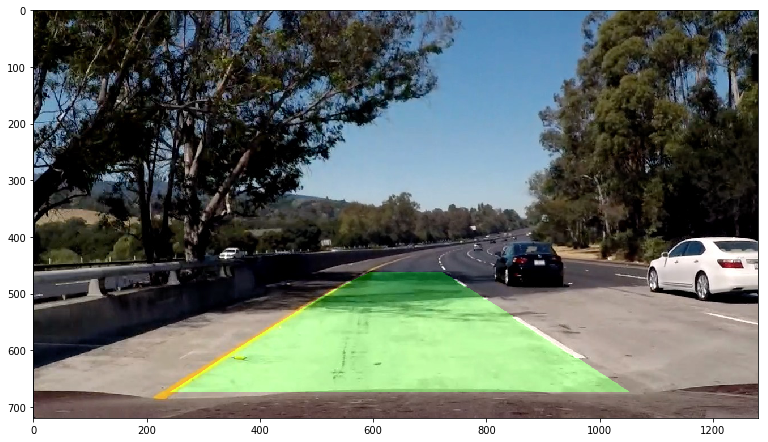

In [26]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped[..., 0]).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(cv2.imread(img_list[img_index]), 1, newwarp, 0.3, 0)
fig = plt.figure(figsize=(15,7.5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

# Pipeline with example pictures 

In [3]:
img_list = sorted(glob.glob('./test_images/*.jpg'))
for i, file in enumerate(img_list):
    # print(i, flush=True)
    img = cv2.imread(file)
    pipeline = continuous_pipeline(binarize_function=binary_mask)
    out_img = pipeline.pipeline(img, debug=True)
    # fig = plt.figure(i, figsize=(10, 5))
    # out_img = cv2.cvtColor(out_img, cv2 .COLOR_BGR2RGB)
    # plt.imshow(out_img)
    cv2.imwrite('./output_images/out_{}.jpg'.format(i), out_img)

0


1


2


3


4


5


6


7


8


# Working with video

In [6]:
video = './project_video.mp4'
clip = VideoFileClip(video)
pipeline = continuous_pipeline(binarize_function=binary_mask)
clip_processed = clip.fl_image(pipeline.pipeline)

In [7]:
clip_processed.write_videofile('./result.mp4', fps=30, audio=False)

[MoviePy] >>>> Building video ./result.mp4


[MoviePy] Writing video ./result.mp4


  0%|          | 0/1513 [00:00<?, ?it/s]

  0%|          | 1/1513 [00:00<03:37,  6.94it/s]

  0%|          | 2/1513 [00:00<03:29,  7.20it/s]

  0%|          | 3/1513 [00:00<03:22,  7.46it/s]

  0%|          | 4/1513 [00:00<03:13,  7.79it/s]

  0%|          | 5/1513 [00:00<03:08,  7.99it/s]

  0%|          | 6/1513 [00:00<03:07,  8.03it/s]

  0%|          | 7/1513 [00:00<03:03,  8.20it/s]

  1%|          | 8/1513 [00:00<02:59,  8.40it/s]

  1%|          | 9/1513 [00:01<03:00,  8.33it/s]

  1%|          | 10/1513 [00:01<02:57,  8.47it/s]

  1%|          | 11/1513 [00:01<02:54,  8.59it/s]

  1%|          | 12/1513 [00:01<02:53,  8.65it/s]

  1%|          | 13/1513 [00:01<02:57,  8.47it/s]

  1%|          | 14/1513 [00:01<03:01,  8.26it/s]

  1%|          | 15/1513 [00:01<03:06,  8.03it/s]

  1%|          | 16/1513 [00:01<03:06,  8.01it/s]

  1%|          | 17/1513 [00:02<03:09,  7.88it/s]

  1%|          | 18/1513 [00:02<03:10,  7.84it/s]

  1%|▏         | 19/1513 [00:02<03:14,  7.69it/s]

  1%|▏         | 20/1513 [00:02<03:10,  7.84it/s]

  1%|▏         | 21/1513 [00:02<03:12,  7.77it/s]

  1%|▏         | 22/1513 [00:02<03:12,  7.73it/s]

  2%|▏         | 23/1513 [00:02<03:09,  7.85it/s]

  2%|▏         | 24/1513 [00:02<03:13,  7.71it/s]

  2%|▏         | 25/1513 [00:03<03:14,  7.64it/s]

  2%|▏         | 26/1513 [00:03<03:12,  7.72it/s]

  2%|▏         | 27/1513 [00:03<03:08,  7.88it/s]

  2%|▏         | 28/1513 [00:03<03:09,  7.85it/s]

  2%|▏         | 29/1513 [00:03<03:07,  7.92it/s]

  2%|▏         | 30/1513 [00:03<03:09,  7.84it/s]

  2%|▏         | 31/1513 [00:03<03:10,  7.80it/s]

  2%|▏         | 32/1513 [00:04<03:11,  7.73it/s]

  2%|▏         | 33/1513 [00:04<03:09,  7.83it/s]

  2%|▏         | 34/1513 [00:04<03:08,  7.86it/s]

  2%|▏         | 35/1513 [00:04<03:05,  7.95it/s]

  2%|▏         | 36/1513 [00:04<03:03,  8.05it/s]

  2%|▏         | 37/1513 [00:04<03:03,  8.03it/s]

  3%|▎         | 38/1513 [00:04<03:00,  8.15it/s]

  3%|▎         | 39/1513 [00:04<03:00,  8.18it/s]

  3%|▎         | 40/1513 [00:04<02:56,  8.35it/s]

  3%|▎         | 41/1513 [00:05<02:58,  8.27it/s]

  3%|▎         | 42/1513 [00:05<03:01,  8.09it/s]

  3%|▎         | 43/1513 [00:05<03:05,  7.91it/s]

  3%|▎         | 44/1513 [00:05<03:05,  7.92it/s]

  3%|▎         | 45/1513 [00:05<03:01,  8.09it/s]

  3%|▎         | 46/1513 [00:05<03:02,  8.03it/s]

  3%|▎         | 47/1513 [00:05<03:08,  7.78it/s]

  3%|▎         | 48/1513 [00:06<03:10,  7.69it/s]

  3%|▎         | 49/1513 [00:06<03:10,  7.70it/s]

  3%|▎         | 50/1513 [00:06<03:03,  7.98it/s]

  3%|▎         | 51/1513 [00:06<03:02,  8.01it/s]

  3%|▎         | 52/1513 [00:06<02:59,  8.12it/s]

  4%|▎         | 53/1513 [00:06<02:59,  8.13it/s]

  4%|▎         | 54/1513 [00:06<02:55,  8.30it/s]

  4%|▎         | 55/1513 [00:06<02:55,  8.33it/s]

  4%|▎         | 56/1513 [00:06<02:52,  8.44it/s]

  4%|▍         | 57/1513 [00:07<02:53,  8.37it/s]

  4%|▍         | 58/1513 [00:07<02:54,  8.36it/s]

  4%|▍         | 59/1513 [00:07<02:53,  8.38it/s]

  4%|▍         | 60/1513 [00:07<02:52,  8.42it/s]

  4%|▍         | 61/1513 [00:07<02:54,  8.33it/s]

  4%|▍         | 62/1513 [00:07<02:55,  8.26it/s]

  4%|▍         | 63/1513 [00:07<02:55,  8.28it/s]

  4%|▍         | 64/1513 [00:07<02:55,  8.26it/s]

  4%|▍         | 65/1513 [00:08<02:58,  8.13it/s]

  4%|▍         | 66/1513 [00:08<03:01,  7.95it/s]

  4%|▍         | 67/1513 [00:08<03:00,  8.00it/s]

  4%|▍         | 68/1513 [00:08<03:01,  7.96it/s]

  5%|▍         | 69/1513 [00:08<03:03,  7.85it/s]

  5%|▍         | 70/1513 [00:08<03:01,  7.94it/s]

  5%|▍         | 71/1513 [00:08<03:01,  7.95it/s]

  5%|▍         | 72/1513 [00:08<03:04,  7.80it/s]

  5%|▍         | 73/1513 [00:09<03:08,  7.64it/s]

  5%|▍         | 74/1513 [00:09<03:07,  7.66it/s]

  5%|▍         | 75/1513 [00:09<03:04,  7.78it/s]

  5%|▌         | 76/1513 [00:09<03:04,  7.80it/s]

  5%|▌         | 77/1513 [00:09<03:02,  7.89it/s]

  5%|▌         | 78/1513 [00:09<02:55,  8.16it/s]

  5%|▌         | 79/1513 [00:09<02:56,  8.12it/s]

  5%|▌         | 80/1513 [00:09<02:57,  8.06it/s]

  5%|▌         | 81/1513 [00:10<03:04,  7.77it/s]

  5%|▌         | 82/1513 [00:10<03:05,  7.71it/s]

  5%|▌         | 83/1513 [00:10<03:02,  7.84it/s]

  6%|▌         | 84/1513 [00:10<02:58,  7.98it/s]

  6%|▌         | 85/1513 [00:10<02:57,  8.07it/s]

  6%|▌         | 86/1513 [00:10<02:58,  7.98it/s]

  6%|▌         | 87/1513 [00:10<03:03,  7.78it/s]

  6%|▌         | 88/1513 [00:10<03:00,  7.89it/s]

  6%|▌         | 89/1513 [00:11<03:02,  7.78it/s]

  6%|▌         | 90/1513 [00:11<03:02,  7.78it/s]

  6%|▌         | 91/1513 [00:11<03:03,  7.77it/s]

  6%|▌         | 92/1513 [00:11<02:58,  7.94it/s]

  6%|▌         | 93/1513 [00:11<02:56,  8.06it/s]

  6%|▌         | 94/1513 [00:11<02:53,  8.18it/s]

  6%|▋         | 95/1513 [00:11<02:52,  8.21it/s]

  6%|▋         | 96/1513 [00:11<02:59,  7.91it/s]

  6%|▋         | 97/1513 [00:12<03:00,  7.85it/s]

  6%|▋         | 98/1513 [00:12<02:57,  7.96it/s]

  7%|▋         | 99/1513 [00:12<02:58,  7.91it/s]

  7%|▋         | 100/1513 [00:12<02:59,  7.89it/s]

  7%|▋         | 101/1513 [00:12<03:03,  7.68it/s]

  7%|▋         | 102/1513 [00:12<02:58,  7.89it/s]

  7%|▋         | 103/1513 [00:12<03:02,  7.72it/s]

  7%|▋         | 104/1513 [00:13<03:01,  7.75it/s]

  7%|▋         | 105/1513 [00:13<02:58,  7.90it/s]

  7%|▋         | 106/1513 [00:13<02:52,  8.17it/s]

  7%|▋         | 107/1513 [00:13<02:52,  8.17it/s]

  7%|▋         | 108/1513 [00:13<02:56,  7.98it/s]

  7%|▋         | 109/1513 [00:13<02:55,  7.99it/s]

  7%|▋         | 110/1513 [00:13<02:53,  8.09it/s]

  7%|▋         | 111/1513 [00:13<02:53,  8.08it/s]

  7%|▋         | 112/1513 [00:14<02:54,  8.05it/s]

  7%|▋         | 113/1513 [00:14<02:50,  8.19it/s]

  8%|▊         | 114/1513 [00:14<02:51,  8.16it/s]

  8%|▊         | 115/1513 [00:14<02:49,  8.23it/s]

  8%|▊         | 116/1513 [00:14<02:48,  8.31it/s]

  8%|▊         | 117/1513 [00:14<02:52,  8.11it/s]

  8%|▊         | 118/1513 [00:14<02:52,  8.10it/s]

  8%|▊         | 119/1513 [00:14<02:52,  8.09it/s]

  8%|▊         | 120/1513 [00:14<02:55,  7.94it/s]

  8%|▊         | 121/1513 [00:15<02:56,  7.88it/s]

  8%|▊         | 122/1513 [00:15<02:59,  7.76it/s]

  8%|▊         | 123/1513 [00:15<02:57,  7.81it/s]

  8%|▊         | 124/1513 [00:15<03:04,  7.54it/s]

  8%|▊         | 125/1513 [00:15<03:08,  7.36it/s]

  8%|▊         | 126/1513 [00:15<03:08,  7.37it/s]

  8%|▊         | 127/1513 [00:15<03:01,  7.65it/s]

  8%|▊         | 128/1513 [00:16<02:56,  7.83it/s]

  9%|▊         | 129/1513 [00:16<02:58,  7.75it/s]

  9%|▊         | 130/1513 [00:16<02:58,  7.77it/s]

  9%|▊         | 131/1513 [00:16<02:57,  7.78it/s]

  9%|▊         | 132/1513 [00:16<02:53,  7.94it/s]

  9%|▉         | 133/1513 [00:16<02:56,  7.80it/s]

  9%|▉         | 134/1513 [00:16<02:48,  8.21it/s]

  9%|▉         | 135/1513 [00:16<02:54,  7.90it/s]

  9%|▉         | 136/1513 [00:17<02:53,  7.95it/s]

  9%|▉         | 137/1513 [00:17<02:55,  7.84it/s]

  9%|▉         | 138/1513 [00:17<02:57,  7.75it/s]

  9%|▉         | 139/1513 [00:17<02:56,  7.80it/s]

  9%|▉         | 140/1513 [00:17<02:58,  7.71it/s]

  9%|▉         | 141/1513 [00:17<02:57,  7.75it/s]

  9%|▉         | 142/1513 [00:17<02:56,  7.78it/s]

  9%|▉         | 143/1513 [00:17<02:55,  7.82it/s]

 10%|▉         | 144/1513 [00:18<02:55,  7.81it/s]

 10%|▉         | 145/1513 [00:18<02:53,  7.87it/s]

 10%|▉         | 146/1513 [00:18<02:49,  8.08it/s]

 10%|▉         | 147/1513 [00:18<02:49,  8.07it/s]

 10%|▉         | 148/1513 [00:18<02:50,  7.99it/s]

 10%|▉         | 149/1513 [00:18<02:48,  8.09it/s]

 10%|▉         | 150/1513 [00:18<02:47,  8.14it/s]

 10%|▉         | 151/1513 [00:18<02:47,  8.13it/s]

 10%|█         | 152/1513 [00:19<02:46,  8.15it/s]

 10%|█         | 153/1513 [00:19<02:45,  8.22it/s]

 10%|█         | 154/1513 [00:19<02:52,  7.90it/s]

 10%|█         | 155/1513 [00:19<02:50,  7.95it/s]

 10%|█         | 156/1513 [00:19<02:50,  7.98it/s]

 10%|█         | 157/1513 [00:19<02:49,  8.01it/s]

 10%|█         | 158/1513 [00:19<02:49,  8.00it/s]

 11%|█         | 159/1513 [00:19<02:45,  8.17it/s]

 11%|█         | 160/1513 [00:20<02:47,  8.10it/s]

 11%|█         | 161/1513 [00:20<02:44,  8.24it/s]

 11%|█         | 162/1513 [00:20<02:45,  8.19it/s]

 11%|█         | 163/1513 [00:20<02:45,  8.15it/s]

 11%|█         | 164/1513 [00:20<02:46,  8.08it/s]

 11%|█         | 165/1513 [00:20<02:47,  8.05it/s]

 11%|█         | 166/1513 [00:20<02:45,  8.14it/s]

 11%|█         | 167/1513 [00:20<02:46,  8.08it/s]

 11%|█         | 168/1513 [00:21<02:44,  8.18it/s]

 11%|█         | 169/1513 [00:21<02:46,  8.06it/s]

 11%|█         | 170/1513 [00:21<02:44,  8.15it/s]

 11%|█▏        | 171/1513 [00:21<02:45,  8.11it/s]

 11%|█▏        | 172/1513 [00:21<02:44,  8.17it/s]

 11%|█▏        | 173/1513 [00:21<02:43,  8.21it/s]

 12%|█▏        | 174/1513 [00:21<02:39,  8.41it/s]

 12%|█▏        | 175/1513 [00:21<02:41,  8.31it/s]

 12%|█▏        | 176/1513 [00:22<02:40,  8.35it/s]

 12%|█▏        | 177/1513 [00:22<02:41,  8.27it/s]

 12%|█▏        | 178/1513 [00:22<02:43,  8.18it/s]

 12%|█▏        | 179/1513 [00:22<02:43,  8.17it/s]

 12%|█▏        | 180/1513 [00:22<02:42,  8.21it/s]

 12%|█▏        | 181/1513 [00:22<02:40,  8.28it/s]

 12%|█▏        | 182/1513 [00:22<02:39,  8.33it/s]

 12%|█▏        | 183/1513 [00:22<02:42,  8.19it/s]

 12%|█▏        | 184/1513 [00:22<02:41,  8.20it/s]

 12%|█▏        | 185/1513 [00:23<02:43,  8.14it/s]

 12%|█▏        | 186/1513 [00:23<02:43,  8.12it/s]

 12%|█▏        | 187/1513 [00:23<02:44,  8.04it/s]

 12%|█▏        | 188/1513 [00:23<02:44,  8.06it/s]

 12%|█▏        | 189/1513 [00:23<02:47,  7.89it/s]

 13%|█▎        | 190/1513 [00:23<02:46,  7.96it/s]

 13%|█▎        | 191/1513 [00:23<02:44,  8.05it/s]

 13%|█▎        | 192/1513 [00:23<02:45,  8.00it/s]

 13%|█▎        | 193/1513 [00:24<02:47,  7.88it/s]

 13%|█▎        | 194/1513 [00:24<02:48,  7.81it/s]

 13%|█▎        | 195/1513 [00:24<02:47,  7.85it/s]

 13%|█▎        | 196/1513 [00:24<02:48,  7.82it/s]

 13%|█▎        | 197/1513 [00:24<02:47,  7.87it/s]

 13%|█▎        | 198/1513 [00:24<02:44,  8.02it/s]

 13%|█▎        | 199/1513 [00:24<02:43,  8.03it/s]

 13%|█▎        | 200/1513 [00:24<02:41,  8.15it/s]

 13%|█▎        | 201/1513 [00:25<02:42,  8.08it/s]

 13%|█▎        | 202/1513 [00:25<02:39,  8.21it/s]

 13%|█▎        | 203/1513 [00:25<02:42,  8.08it/s]

 13%|█▎        | 204/1513 [00:25<02:42,  8.07it/s]

 14%|█▎        | 205/1513 [00:25<02:39,  8.18it/s]

 14%|█▎        | 206/1513 [00:25<02:36,  8.35it/s]

 14%|█▎        | 207/1513 [00:25<02:35,  8.38it/s]

 14%|█▎        | 208/1513 [00:25<02:36,  8.37it/s]

 14%|█▍        | 209/1513 [00:26<02:33,  8.50it/s]

 14%|█▍        | 210/1513 [00:26<02:35,  8.38it/s]

 14%|█▍        | 211/1513 [00:26<02:39,  8.14it/s]

 14%|█▍        | 212/1513 [00:26<02:39,  8.15it/s]

 14%|█▍        | 213/1513 [00:26<02:41,  8.06it/s]

 14%|█▍        | 214/1513 [00:26<02:42,  8.01it/s]

 14%|█▍        | 215/1513 [00:26<02:42,  7.97it/s]

 14%|█▍        | 216/1513 [00:26<02:41,  8.03it/s]

 14%|█▍        | 217/1513 [00:27<02:42,  7.97it/s]

 14%|█▍        | 218/1513 [00:27<02:39,  8.13it/s]

 14%|█▍        | 219/1513 [00:27<02:40,  8.05it/s]

 15%|█▍        | 220/1513 [00:27<02:43,  7.89it/s]

 15%|█▍        | 221/1513 [00:27<02:45,  7.80it/s]

 15%|█▍        | 222/1513 [00:27<02:42,  7.96it/s]

 15%|█▍        | 223/1513 [00:27<02:41,  7.98it/s]

 15%|█▍        | 224/1513 [00:27<02:39,  8.07it/s]

 15%|█▍        | 225/1513 [00:28<02:41,  7.96it/s]

 15%|█▍        | 226/1513 [00:28<02:43,  7.89it/s]

 15%|█▌        | 227/1513 [00:28<02:42,  7.93it/s]

 15%|█▌        | 228/1513 [00:28<02:40,  7.99it/s]

 15%|█▌        | 229/1513 [00:28<02:41,  7.93it/s]

 15%|█▌        | 230/1513 [00:28<02:43,  7.85it/s]

 15%|█▌        | 231/1513 [00:28<02:40,  8.01it/s]

 15%|█▌        | 232/1513 [00:28<02:42,  7.89it/s]

 15%|█▌        | 233/1513 [00:29<02:41,  7.94it/s]

 15%|█▌        | 234/1513 [00:29<02:36,  8.17it/s]

 16%|█▌        | 235/1513 [00:29<02:42,  7.87it/s]

 16%|█▌        | 236/1513 [00:29<02:42,  7.87it/s]

 16%|█▌        | 237/1513 [00:29<02:41,  7.89it/s]

 16%|█▌        | 238/1513 [00:29<02:44,  7.74it/s]

 16%|█▌        | 239/1513 [00:29<02:44,  7.76it/s]

 16%|█▌        | 240/1513 [00:29<02:41,  7.88it/s]

 16%|█▌        | 241/1513 [00:30<02:37,  8.10it/s]

 16%|█▌        | 242/1513 [00:30<02:33,  8.28it/s]

 16%|█▌        | 243/1513 [00:30<02:32,  8.31it/s]

 16%|█▌        | 244/1513 [00:30<02:37,  8.05it/s]

 16%|█▌        | 245/1513 [00:30<02:38,  7.99it/s]

 16%|█▋        | 246/1513 [00:30<02:41,  7.84it/s]

 16%|█▋        | 247/1513 [00:30<02:44,  7.71it/s]

 16%|█▋        | 248/1513 [00:30<02:43,  7.76it/s]

 16%|█▋        | 249/1513 [00:31<02:42,  7.79it/s]

 17%|█▋        | 250/1513 [00:31<02:39,  7.91it/s]

 17%|█▋        | 251/1513 [00:31<02:40,  7.85it/s]

 17%|█▋        | 252/1513 [00:31<02:40,  7.88it/s]

 17%|█▋        | 253/1513 [00:31<02:41,  7.83it/s]

 17%|█▋        | 254/1513 [00:31<02:38,  7.92it/s]

 17%|█▋        | 255/1513 [00:31<02:39,  7.90it/s]

 17%|█▋        | 256/1513 [00:31<02:37,  7.97it/s]

 17%|█▋        | 257/1513 [00:32<02:35,  8.06it/s]

 17%|█▋        | 258/1513 [00:32<02:34,  8.14it/s]

 17%|█▋        | 259/1513 [00:32<02:33,  8.18it/s]

 17%|█▋        | 260/1513 [00:32<02:27,  8.47it/s]

 17%|█▋        | 261/1513 [00:32<02:29,  8.35it/s]

 17%|█▋        | 262/1513 [00:32<02:29,  8.34it/s]

 17%|█▋        | 263/1513 [00:32<02:33,  8.17it/s]

 17%|█▋        | 264/1513 [00:32<02:33,  8.12it/s]

 18%|█▊        | 265/1513 [00:33<02:29,  8.34it/s]

 18%|█▊        | 266/1513 [00:33<02:33,  8.11it/s]

 18%|█▊        | 267/1513 [00:33<02:37,  7.90it/s]

 18%|█▊        | 268/1513 [00:33<02:35,  8.03it/s]

 18%|█▊        | 269/1513 [00:33<02:37,  7.90it/s]

 18%|█▊        | 270/1513 [00:33<02:37,  7.87it/s]

 18%|█▊        | 271/1513 [00:33<02:38,  7.83it/s]

 18%|█▊        | 272/1513 [00:33<02:37,  7.90it/s]

 18%|█▊        | 273/1513 [00:34<02:37,  7.89it/s]

 18%|█▊        | 274/1513 [00:34<02:38,  7.83it/s]

 18%|█▊        | 275/1513 [00:34<02:43,  7.58it/s]

 18%|█▊        | 276/1513 [00:34<02:40,  7.73it/s]

 18%|█▊        | 277/1513 [00:34<02:41,  7.66it/s]

 18%|█▊        | 278/1513 [00:34<02:40,  7.70it/s]

 18%|█▊        | 279/1513 [00:34<02:39,  7.75it/s]

 19%|█▊        | 280/1513 [00:35<02:36,  7.87it/s]

 19%|█▊        | 281/1513 [00:35<02:39,  7.72it/s]

 19%|█▊        | 282/1513 [00:35<02:38,  7.78it/s]

 19%|█▊        | 283/1513 [00:35<02:36,  7.85it/s]

 19%|█▉        | 284/1513 [00:35<02:36,  7.84it/s]

 19%|█▉        | 285/1513 [00:35<02:38,  7.76it/s]

 19%|█▉        | 286/1513 [00:35<02:33,  7.97it/s]

 19%|█▉        | 287/1513 [00:35<02:30,  8.14it/s]

 19%|█▉        | 288/1513 [00:36<02:26,  8.33it/s]

 19%|█▉        | 289/1513 [00:36<02:27,  8.30it/s]

 19%|█▉        | 290/1513 [00:36<02:30,  8.11it/s]

 19%|█▉        | 291/1513 [00:36<02:33,  7.98it/s]

 19%|█▉        | 292/1513 [00:36<02:33,  7.94it/s]

 19%|█▉        | 293/1513 [00:36<02:33,  7.96it/s]

 19%|█▉        | 294/1513 [00:36<02:32,  8.00it/s]

 19%|█▉        | 295/1513 [00:36<02:31,  8.02it/s]

 20%|█▉        | 296/1513 [00:36<02:28,  8.20it/s]

 20%|█▉        | 297/1513 [00:37<02:25,  8.36it/s]

 20%|█▉        | 298/1513 [00:37<02:25,  8.33it/s]

 20%|█▉        | 299/1513 [00:37<02:22,  8.51it/s]

 20%|█▉        | 300/1513 [00:37<02:22,  8.53it/s]

 20%|█▉        | 301/1513 [00:37<02:28,  8.14it/s]

 20%|█▉        | 302/1513 [00:37<02:23,  8.43it/s]

 20%|██        | 303/1513 [00:37<02:27,  8.21it/s]

 20%|██        | 304/1513 [00:37<02:28,  8.16it/s]

 20%|██        | 305/1513 [00:38<02:28,  8.13it/s]

 20%|██        | 306/1513 [00:38<02:25,  8.30it/s]

 20%|██        | 307/1513 [00:38<02:27,  8.16it/s]

 20%|██        | 308/1513 [00:38<02:30,  8.03it/s]

 20%|██        | 309/1513 [00:38<02:32,  7.88it/s]

 20%|██        | 310/1513 [00:38<02:34,  7.78it/s]

 21%|██        | 311/1513 [00:38<02:35,  7.75it/s]

 21%|██        | 312/1513 [00:38<02:29,  8.05it/s]

 21%|██        | 313/1513 [00:39<02:27,  8.12it/s]

 21%|██        | 314/1513 [00:39<02:21,  8.46it/s]

 21%|██        | 315/1513 [00:39<02:23,  8.35it/s]

 21%|██        | 316/1513 [00:39<02:24,  8.26it/s]

 21%|██        | 317/1513 [00:39<02:24,  8.28it/s]

 21%|██        | 318/1513 [00:39<02:24,  8.29it/s]

 21%|██        | 319/1513 [00:39<02:27,  8.09it/s]

 21%|██        | 320/1513 [00:39<02:28,  8.02it/s]

 21%|██        | 321/1513 [00:40<02:29,  7.95it/s]

 21%|██▏       | 322/1513 [00:40<02:34,  7.72it/s]

 21%|██▏       | 323/1513 [00:40<02:32,  7.81it/s]

 21%|██▏       | 324/1513 [00:40<02:28,  8.00it/s]

 21%|██▏       | 325/1513 [00:40<02:25,  8.16it/s]

 22%|██▏       | 326/1513 [00:40<02:27,  8.02it/s]

 22%|██▏       | 327/1513 [00:40<02:30,  7.90it/s]

 22%|██▏       | 328/1513 [00:40<02:32,  7.77it/s]

 22%|██▏       | 329/1513 [00:41<02:33,  7.70it/s]

 22%|██▏       | 330/1513 [00:41<02:32,  7.77it/s]

 22%|██▏       | 331/1513 [00:41<02:32,  7.73it/s]

 22%|██▏       | 332/1513 [00:41<02:30,  7.84it/s]

 22%|██▏       | 333/1513 [00:41<02:32,  7.74it/s]

 22%|██▏       | 334/1513 [00:41<02:34,  7.64it/s]

 22%|██▏       | 335/1513 [00:41<02:42,  7.26it/s]

 22%|██▏       | 336/1513 [00:42<02:44,  7.13it/s]

 22%|██▏       | 337/1513 [00:42<02:42,  7.22it/s]

 22%|██▏       | 338/1513 [00:42<02:42,  7.23it/s]

 22%|██▏       | 339/1513 [00:42<02:36,  7.50it/s]

 22%|██▏       | 340/1513 [00:42<02:40,  7.33it/s]

 23%|██▎       | 341/1513 [00:42<02:36,  7.47it/s]

 23%|██▎       | 342/1513 [00:42<02:34,  7.59it/s]

 23%|██▎       | 343/1513 [00:42<02:34,  7.56it/s]

 23%|██▎       | 344/1513 [00:43<02:33,  7.62it/s]

 23%|██▎       | 345/1513 [00:43<02:33,  7.61it/s]

 23%|██▎       | 346/1513 [00:43<02:31,  7.68it/s]

 23%|██▎       | 347/1513 [00:43<02:30,  7.73it/s]

 23%|██▎       | 348/1513 [00:43<02:29,  7.79it/s]

 23%|██▎       | 349/1513 [00:43<02:29,  7.78it/s]

 23%|██▎       | 350/1513 [00:43<02:31,  7.67it/s]

 23%|██▎       | 351/1513 [00:43<02:31,  7.67it/s]

 23%|██▎       | 352/1513 [00:44<02:29,  7.76it/s]

 23%|██▎       | 353/1513 [00:44<02:26,  7.93it/s]

 23%|██▎       | 354/1513 [00:44<02:23,  8.05it/s]

 23%|██▎       | 355/1513 [00:44<02:24,  8.04it/s]

 24%|██▎       | 356/1513 [00:44<02:22,  8.14it/s]

 24%|██▎       | 357/1513 [00:44<02:35,  7.43it/s]

 24%|██▎       | 358/1513 [00:44<02:35,  7.42it/s]

 24%|██▎       | 359/1513 [00:45<02:37,  7.32it/s]

 24%|██▍       | 360/1513 [00:45<02:35,  7.40it/s]

 24%|██▍       | 361/1513 [00:45<02:30,  7.66it/s]

 24%|██▍       | 362/1513 [00:45<02:26,  7.86it/s]

 24%|██▍       | 363/1513 [00:45<02:24,  7.95it/s]

 24%|██▍       | 364/1513 [00:45<02:23,  7.99it/s]

 24%|██▍       | 365/1513 [00:45<02:24,  7.95it/s]

 24%|██▍       | 366/1513 [00:45<02:25,  7.86it/s]

 24%|██▍       | 367/1513 [00:46<02:33,  7.45it/s]

 24%|██▍       | 368/1513 [00:46<02:28,  7.73it/s]

 24%|██▍       | 369/1513 [00:46<02:25,  7.84it/s]

 24%|██▍       | 370/1513 [00:46<02:23,  7.94it/s]

 25%|██▍       | 371/1513 [00:46<02:24,  7.89it/s]

 25%|██▍       | 372/1513 [00:46<02:24,  7.90it/s]

 25%|██▍       | 373/1513 [00:46<02:22,  7.98it/s]

 25%|██▍       | 374/1513 [00:46<02:21,  8.07it/s]

 25%|██▍       | 375/1513 [00:47<02:19,  8.17it/s]

 25%|██▍       | 376/1513 [00:47<02:19,  8.13it/s]

 25%|██▍       | 377/1513 [00:47<02:30,  7.54it/s]

 25%|██▍       | 378/1513 [00:47<02:30,  7.55it/s]

 25%|██▌       | 379/1513 [00:47<02:29,  7.61it/s]

 25%|██▌       | 380/1513 [00:47<02:25,  7.81it/s]

 25%|██▌       | 381/1513 [00:47<02:28,  7.62it/s]

 25%|██▌       | 382/1513 [00:47<02:24,  7.83it/s]

 25%|██▌       | 383/1513 [00:48<02:23,  7.90it/s]

 25%|██▌       | 384/1513 [00:48<02:20,  8.01it/s]

 25%|██▌       | 385/1513 [00:48<02:27,  7.65it/s]

 26%|██▌       | 386/1513 [00:48<02:24,  7.78it/s]

 26%|██▌       | 387/1513 [00:48<02:24,  7.81it/s]

 26%|██▌       | 388/1513 [00:48<02:23,  7.81it/s]

 26%|██▌       | 389/1513 [00:48<02:27,  7.62it/s]

 26%|██▌       | 390/1513 [00:49<02:26,  7.67it/s]

 26%|██▌       | 391/1513 [00:49<02:26,  7.66it/s]

 26%|██▌       | 392/1513 [00:49<02:25,  7.70it/s]

 26%|██▌       | 393/1513 [00:49<02:27,  7.61it/s]

 26%|██▌       | 394/1513 [00:49<02:27,  7.60it/s]

 26%|██▌       | 395/1513 [00:49<02:28,  7.53it/s]

 26%|██▌       | 396/1513 [00:49<02:25,  7.68it/s]

 26%|██▌       | 397/1513 [00:49<02:23,  7.77it/s]

 26%|██▋       | 398/1513 [00:50<02:21,  7.87it/s]

 26%|██▋       | 399/1513 [00:50<02:26,  7.59it/s]

 26%|██▋       | 400/1513 [00:50<02:28,  7.51it/s]

 27%|██▋       | 401/1513 [00:50<02:26,  7.57it/s]

 27%|██▋       | 402/1513 [00:50<02:23,  7.72it/s]

 27%|██▋       | 403/1513 [00:50<02:24,  7.71it/s]

 27%|██▋       | 404/1513 [00:50<02:22,  7.81it/s]

 27%|██▋       | 405/1513 [00:50<02:21,  7.81it/s]

 27%|██▋       | 406/1513 [00:51<02:17,  8.06it/s]

 27%|██▋       | 407/1513 [00:51<02:19,  7.90it/s]

 27%|██▋       | 408/1513 [00:51<02:20,  7.84it/s]

 27%|██▋       | 409/1513 [00:51<02:31,  7.30it/s]

 27%|██▋       | 410/1513 [00:51<02:29,  7.40it/s]

 27%|██▋       | 411/1513 [00:51<02:27,  7.47it/s]

 27%|██▋       | 412/1513 [00:51<02:25,  7.57it/s]

 27%|██▋       | 413/1513 [00:52<02:24,  7.59it/s]

 27%|██▋       | 414/1513 [00:52<02:22,  7.73it/s]

 27%|██▋       | 415/1513 [00:52<02:20,  7.79it/s]

 27%|██▋       | 416/1513 [00:52<02:32,  7.21it/s]

 28%|██▊       | 417/1513 [00:52<02:34,  7.12it/s]

 28%|██▊       | 418/1513 [00:52<02:32,  7.18it/s]

 28%|██▊       | 419/1513 [00:52<02:29,  7.33it/s]

 28%|██▊       | 420/1513 [00:52<02:21,  7.72it/s]

 28%|██▊       | 421/1513 [00:53<02:17,  7.96it/s]

 28%|██▊       | 422/1513 [00:53<02:12,  8.23it/s]

 28%|██▊       | 423/1513 [00:53<02:13,  8.16it/s]

 28%|██▊       | 424/1513 [00:53<02:29,  7.27it/s]

 28%|██▊       | 425/1513 [00:53<02:32,  7.14it/s]

 28%|██▊       | 426/1513 [00:53<02:33,  7.09it/s]

 28%|██▊       | 427/1513 [00:53<02:33,  7.06it/s]

 28%|██▊       | 428/1513 [00:54<02:27,  7.35it/s]

 28%|██▊       | 429/1513 [00:54<02:32,  7.12it/s]

 28%|██▊       | 430/1513 [00:54<02:27,  7.32it/s]

 28%|██▊       | 431/1513 [00:54<02:23,  7.55it/s]

 29%|██▊       | 432/1513 [00:54<02:29,  7.24it/s]

 29%|██▊       | 433/1513 [00:54<02:34,  7.01it/s]

 29%|██▊       | 434/1513 [00:54<02:35,  6.92it/s]

 29%|██▉       | 435/1513 [00:55<02:43,  6.60it/s]

 29%|██▉       | 436/1513 [00:55<02:35,  6.94it/s]

 29%|██▉       | 437/1513 [00:55<02:31,  7.12it/s]

 29%|██▉       | 438/1513 [00:55<02:26,  7.33it/s]

 29%|██▉       | 439/1513 [00:55<02:24,  7.44it/s]

 29%|██▉       | 440/1513 [00:55<02:20,  7.62it/s]

 29%|██▉       | 441/1513 [00:55<02:21,  7.56it/s]

 29%|██▉       | 442/1513 [00:55<02:23,  7.48it/s]

 29%|██▉       | 443/1513 [00:56<02:20,  7.61it/s]

 29%|██▉       | 444/1513 [00:56<02:17,  7.80it/s]

 29%|██▉       | 445/1513 [00:56<02:20,  7.58it/s]

 29%|██▉       | 446/1513 [00:56<02:23,  7.42it/s]

 30%|██▉       | 447/1513 [00:56<02:23,  7.44it/s]

 30%|██▉       | 448/1513 [00:56<02:24,  7.38it/s]

 30%|██▉       | 449/1513 [00:56<02:24,  7.37it/s]

 30%|██▉       | 450/1513 [00:57<02:20,  7.57it/s]

 30%|██▉       | 451/1513 [00:57<02:22,  7.48it/s]

 30%|██▉       | 452/1513 [00:57<02:21,  7.50it/s]

 30%|██▉       | 453/1513 [00:57<02:20,  7.54it/s]

 30%|███       | 454/1513 [00:57<02:17,  7.70it/s]

 30%|███       | 455/1513 [00:57<02:13,  7.90it/s]

 30%|███       | 456/1513 [00:57<02:17,  7.71it/s]

 30%|███       | 457/1513 [00:57<02:17,  7.66it/s]

 30%|███       | 458/1513 [00:58<02:19,  7.58it/s]

 30%|███       | 459/1513 [00:58<02:19,  7.58it/s]

 30%|███       | 460/1513 [00:58<02:16,  7.69it/s]

 30%|███       | 461/1513 [00:58<02:18,  7.58it/s]

 31%|███       | 462/1513 [00:58<02:16,  7.67it/s]

 31%|███       | 463/1513 [00:58<02:16,  7.71it/s]

 31%|███       | 464/1513 [00:58<02:12,  7.90it/s]

 31%|███       | 465/1513 [00:58<02:20,  7.47it/s]

 31%|███       | 466/1513 [00:59<02:18,  7.57it/s]

 31%|███       | 467/1513 [00:59<02:18,  7.54it/s]

 31%|███       | 468/1513 [00:59<02:15,  7.70it/s]

 31%|███       | 469/1513 [00:59<02:15,  7.70it/s]

 31%|███       | 470/1513 [00:59<02:11,  7.92it/s]

 31%|███       | 471/1513 [00:59<02:14,  7.74it/s]

 31%|███       | 472/1513 [00:59<02:17,  7.56it/s]

 31%|███▏      | 473/1513 [01:00<02:19,  7.47it/s]

 31%|███▏      | 474/1513 [01:00<02:14,  7.73it/s]

 31%|███▏      | 475/1513 [01:00<02:13,  7.80it/s]

 31%|███▏      | 476/1513 [01:00<02:10,  7.92it/s]

 32%|███▏      | 477/1513 [01:00<02:12,  7.80it/s]

 32%|███▏      | 478/1513 [01:00<02:10,  7.94it/s]

 32%|███▏      | 479/1513 [01:00<02:11,  7.86it/s]

 32%|███▏      | 480/1513 [01:00<02:11,  7.88it/s]

 32%|███▏      | 481/1513 [01:01<02:15,  7.61it/s]

 32%|███▏      | 482/1513 [01:01<02:15,  7.64it/s]

 32%|███▏      | 483/1513 [01:01<02:17,  7.49it/s]

 32%|███▏      | 484/1513 [01:01<02:19,  7.36it/s]

 32%|███▏      | 485/1513 [01:01<02:23,  7.18it/s]

 32%|███▏      | 486/1513 [01:01<02:24,  7.11it/s]

 32%|███▏      | 487/1513 [01:01<02:17,  7.44it/s]

 32%|███▏      | 488/1513 [01:02<02:15,  7.58it/s]

 32%|███▏      | 489/1513 [01:02<02:15,  7.54it/s]

 32%|███▏      | 490/1513 [01:02<02:09,  7.89it/s]

 32%|███▏      | 491/1513 [01:02<02:08,  7.98it/s]

 33%|███▎      | 492/1513 [01:02<02:08,  7.94it/s]

 33%|███▎      | 493/1513 [01:02<02:15,  7.52it/s]

 33%|███▎      | 494/1513 [01:02<02:14,  7.60it/s]

 33%|███▎      | 495/1513 [01:02<02:14,  7.55it/s]

 33%|███▎      | 496/1513 [01:03<02:15,  7.53it/s]

 33%|███▎      | 497/1513 [01:03<02:13,  7.62it/s]

 33%|███▎      | 498/1513 [01:03<02:13,  7.62it/s]

 33%|███▎      | 499/1513 [01:03<02:12,  7.64it/s]

 33%|███▎      | 500/1513 [01:03<02:18,  7.33it/s]

 33%|███▎      | 501/1513 [01:03<02:20,  7.21it/s]

 33%|███▎      | 502/1513 [01:03<02:17,  7.33it/s]

 33%|███▎      | 503/1513 [01:03<02:17,  7.35it/s]

 33%|███▎      | 504/1513 [01:04<02:15,  7.46it/s]

 33%|███▎      | 505/1513 [01:04<02:12,  7.63it/s]

 33%|███▎      | 506/1513 [01:04<02:13,  7.52it/s]

 34%|███▎      | 507/1513 [01:04<02:18,  7.27it/s]

 34%|███▎      | 508/1513 [01:04<02:18,  7.23it/s]

 34%|███▎      | 509/1513 [01:04<02:16,  7.38it/s]

 34%|███▎      | 510/1513 [01:04<02:13,  7.50it/s]

 34%|███▍      | 511/1513 [01:05<02:17,  7.29it/s]

 34%|███▍      | 512/1513 [01:05<02:13,  7.51it/s]

 34%|███▍      | 513/1513 [01:05<02:09,  7.72it/s]

 34%|███▍      | 514/1513 [01:05<02:07,  7.83it/s]

 34%|███▍      | 515/1513 [01:05<02:09,  7.68it/s]

 34%|███▍      | 516/1513 [01:05<02:08,  7.73it/s]

 34%|███▍      | 517/1513 [01:05<02:06,  7.87it/s]

 34%|███▍      | 518/1513 [01:05<02:05,  7.90it/s]

 34%|███▍      | 519/1513 [01:06<02:02,  8.12it/s]

 34%|███▍      | 520/1513 [01:06<02:00,  8.27it/s]

 34%|███▍      | 521/1513 [01:06<02:00,  8.26it/s]

 35%|███▍      | 522/1513 [01:06<02:00,  8.22it/s]

 35%|███▍      | 523/1513 [01:06<02:00,  8.19it/s]

 35%|███▍      | 524/1513 [01:06<02:00,  8.19it/s]

 35%|███▍      | 525/1513 [01:06<02:00,  8.23it/s]

 35%|███▍      | 526/1513 [01:06<02:00,  8.18it/s]

 35%|███▍      | 527/1513 [01:07<02:01,  8.09it/s]

 35%|███▍      | 528/1513 [01:07<02:00,  8.19it/s]

 35%|███▍      | 529/1513 [01:07<02:01,  8.10it/s]

 35%|███▌      | 530/1513 [01:07<01:58,  8.30it/s]

 35%|███▌      | 531/1513 [01:07<01:57,  8.38it/s]

 35%|███▌      | 532/1513 [01:07<01:58,  8.25it/s]

 35%|███▌      | 533/1513 [01:07<02:00,  8.11it/s]

 35%|███▌      | 534/1513 [01:07<02:00,  8.10it/s]

 35%|███▌      | 535/1513 [01:08<02:03,  7.94it/s]

 35%|███▌      | 536/1513 [01:08<02:03,  7.91it/s]

 35%|███▌      | 537/1513 [01:08<02:04,  7.82it/s]

 36%|███▌      | 538/1513 [01:08<02:00,  8.09it/s]

 36%|███▌      | 539/1513 [01:08<02:05,  7.78it/s]

 36%|███▌      | 540/1513 [01:08<02:04,  7.80it/s]

 36%|███▌      | 541/1513 [01:08<02:05,  7.78it/s]

 36%|███▌      | 542/1513 [01:08<02:05,  7.71it/s]

 36%|███▌      | 543/1513 [01:09<02:06,  7.69it/s]

 36%|███▌      | 544/1513 [01:09<02:07,  7.60it/s]

 36%|███▌      | 545/1513 [01:09<02:06,  7.65it/s]

 36%|███▌      | 546/1513 [01:09<02:07,  7.56it/s]

 36%|███▌      | 547/1513 [01:09<02:08,  7.53it/s]

 36%|███▌      | 548/1513 [01:09<02:03,  7.82it/s]

 36%|███▋      | 549/1513 [01:09<02:01,  7.94it/s]

 36%|███▋      | 550/1513 [01:09<02:00,  7.99it/s]

 36%|███▋      | 551/1513 [01:10<02:00,  7.98it/s]

 36%|███▋      | 552/1513 [01:10<01:59,  8.03it/s]

 37%|███▋      | 553/1513 [01:10<01:59,  8.05it/s]

 37%|███▋      | 554/1513 [01:10<01:56,  8.20it/s]

 37%|███▋      | 555/1513 [01:10<02:01,  7.86it/s]

 37%|███▋      | 556/1513 [01:10<02:00,  7.91it/s]

 37%|███▋      | 557/1513 [01:10<02:01,  7.85it/s]

 37%|███▋      | 558/1513 [01:10<02:05,  7.59it/s]

 37%|███▋      | 559/1513 [01:11<02:08,  7.44it/s]

 37%|███▋      | 560/1513 [01:11<02:05,  7.58it/s]

 37%|███▋      | 561/1513 [01:11<02:04,  7.63it/s]

 37%|███▋      | 562/1513 [01:11<02:05,  7.59it/s]

 37%|███▋      | 563/1513 [01:11<02:05,  7.59it/s]

 37%|███▋      | 564/1513 [01:11<02:05,  7.56it/s]

 37%|███▋      | 565/1513 [01:11<02:03,  7.68it/s]

 37%|███▋      | 566/1513 [01:12<02:02,  7.73it/s]

 37%|███▋      | 567/1513 [01:12<02:03,  7.66it/s]

 38%|███▊      | 568/1513 [01:12<02:03,  7.64it/s]

 38%|███▊      | 569/1513 [01:12<02:05,  7.54it/s]

 38%|███▊      | 570/1513 [01:12<02:03,  7.61it/s]

 38%|███▊      | 571/1513 [01:12<02:02,  7.71it/s]

 38%|███▊      | 572/1513 [01:12<01:58,  7.93it/s]

 38%|███▊      | 573/1513 [01:12<02:01,  7.72it/s]

 38%|███▊      | 574/1513 [01:13<01:59,  7.85it/s]

 38%|███▊      | 575/1513 [01:13<02:00,  7.76it/s]

 38%|███▊      | 576/1513 [01:13<01:57,  8.01it/s]

 38%|███▊      | 577/1513 [01:13<01:58,  7.90it/s]

 38%|███▊      | 578/1513 [01:13<02:00,  7.77it/s]

 38%|███▊      | 579/1513 [01:13<01:58,  7.87it/s]

 38%|███▊      | 580/1513 [01:13<01:57,  7.91it/s]

 38%|███▊      | 581/1513 [01:13<01:59,  7.82it/s]

 38%|███▊      | 582/1513 [01:14<01:59,  7.79it/s]

 39%|███▊      | 583/1513 [01:14<01:59,  7.79it/s]

 39%|███▊      | 584/1513 [01:14<01:58,  7.85it/s]

 39%|███▊      | 585/1513 [01:14<01:56,  7.94it/s]

 39%|███▊      | 586/1513 [01:14<01:55,  8.06it/s]

 39%|███▉      | 587/1513 [01:14<01:52,  8.27it/s]

 39%|███▉      | 588/1513 [01:14<01:53,  8.16it/s]

 39%|███▉      | 589/1513 [01:14<01:53,  8.15it/s]

 39%|███▉      | 590/1513 [01:15<01:52,  8.20it/s]

 39%|███▉      | 591/1513 [01:15<01:57,  7.87it/s]

 39%|███▉      | 592/1513 [01:15<01:57,  7.86it/s]

 39%|███▉      | 593/1513 [01:15<01:55,  7.93it/s]

 39%|███▉      | 594/1513 [01:15<01:54,  8.01it/s]

 39%|███▉      | 595/1513 [01:15<01:53,  8.12it/s]

 39%|███▉      | 596/1513 [01:15<01:51,  8.26it/s]

 39%|███▉      | 597/1513 [01:15<01:49,  8.36it/s]

 40%|███▉      | 598/1513 [01:16<01:53,  8.10it/s]

 40%|███▉      | 599/1513 [01:16<01:56,  7.87it/s]

 40%|███▉      | 600/1513 [01:16<01:55,  7.91it/s]

 40%|███▉      | 601/1513 [01:16<01:53,  8.01it/s]

 40%|███▉      | 602/1513 [01:16<01:50,  8.21it/s]

 40%|███▉      | 603/1513 [01:16<01:54,  7.97it/s]

 40%|███▉      | 604/1513 [01:16<01:55,  7.90it/s]

 40%|███▉      | 605/1513 [01:16<01:56,  7.78it/s]

 40%|████      | 606/1513 [01:17<01:57,  7.73it/s]

 40%|████      | 607/1513 [01:17<01:57,  7.71it/s]

 40%|████      | 608/1513 [01:17<01:55,  7.81it/s]

 40%|████      | 609/1513 [01:17<01:54,  7.87it/s]

 40%|████      | 610/1513 [01:17<01:53,  7.96it/s]

 40%|████      | 611/1513 [01:17<01:53,  7.95it/s]

 40%|████      | 612/1513 [01:17<01:52,  7.99it/s]

 41%|████      | 613/1513 [01:17<01:55,  7.80it/s]

 41%|████      | 614/1513 [01:18<01:55,  7.77it/s]

 41%|████      | 615/1513 [01:18<01:57,  7.65it/s]

 41%|████      | 616/1513 [01:18<01:55,  7.77it/s]

 41%|████      | 617/1513 [01:18<01:55,  7.79it/s]

 41%|████      | 618/1513 [01:18<01:55,  7.74it/s]

 41%|████      | 619/1513 [01:18<01:53,  7.87it/s]

 41%|████      | 620/1513 [01:18<01:51,  8.01it/s]

 41%|████      | 621/1513 [01:18<01:48,  8.24it/s]

 41%|████      | 622/1513 [01:19<01:46,  8.34it/s]

 41%|████      | 623/1513 [01:19<01:48,  8.22it/s]

 41%|████      | 624/1513 [01:19<01:48,  8.18it/s]

 41%|████▏     | 625/1513 [01:19<01:52,  7.90it/s]

 41%|████▏     | 626/1513 [01:19<01:52,  7.86it/s]

 41%|████▏     | 627/1513 [01:19<01:54,  7.75it/s]

 42%|████▏     | 628/1513 [01:19<01:54,  7.71it/s]

 42%|████▏     | 629/1513 [01:20<01:55,  7.66it/s]

 42%|████▏     | 630/1513 [01:20<01:57,  7.54it/s]

 42%|████▏     | 631/1513 [01:20<01:56,  7.57it/s]

 42%|████▏     | 632/1513 [01:20<01:52,  7.84it/s]

 42%|████▏     | 633/1513 [01:20<01:51,  7.90it/s]

 42%|████▏     | 634/1513 [01:20<01:50,  7.96it/s]

 42%|████▏     | 635/1513 [01:20<01:49,  7.98it/s]

 42%|████▏     | 636/1513 [01:20<01:48,  8.09it/s]

 42%|████▏     | 637/1513 [01:21<01:48,  8.07it/s]

 42%|████▏     | 638/1513 [01:21<01:48,  8.06it/s]

 42%|████▏     | 639/1513 [01:21<01:51,  7.86it/s]

 42%|████▏     | 640/1513 [01:21<01:51,  7.86it/s]

 42%|████▏     | 641/1513 [01:21<01:52,  7.75it/s]

 42%|████▏     | 642/1513 [01:21<01:52,  7.71it/s]

 42%|████▏     | 643/1513 [01:21<01:56,  7.49it/s]

 43%|████▎     | 644/1513 [01:21<01:55,  7.52it/s]

 43%|████▎     | 645/1513 [01:22<01:53,  7.63it/s]

 43%|████▎     | 646/1513 [01:22<01:52,  7.72it/s]

 43%|████▎     | 647/1513 [01:22<01:49,  7.88it/s]

 43%|████▎     | 648/1513 [01:22<01:49,  7.89it/s]

 43%|████▎     | 649/1513 [01:22<01:50,  7.84it/s]

 43%|████▎     | 650/1513 [01:22<01:51,  7.75it/s]

 43%|████▎     | 651/1513 [01:22<01:54,  7.54it/s]

 43%|████▎     | 652/1513 [01:22<01:55,  7.45it/s]

 43%|████▎     | 653/1513 [01:23<01:56,  7.39it/s]

 43%|████▎     | 654/1513 [01:23<01:54,  7.50it/s]

 43%|████▎     | 655/1513 [01:23<01:51,  7.72it/s]

 43%|████▎     | 656/1513 [01:23<01:49,  7.83it/s]

 43%|████▎     | 657/1513 [01:23<01:49,  7.82it/s]

 43%|████▎     | 658/1513 [01:23<01:50,  7.77it/s]

 44%|████▎     | 659/1513 [01:23<01:50,  7.74it/s]

 44%|████▎     | 660/1513 [01:23<01:50,  7.72it/s]

 44%|████▎     | 661/1513 [01:24<01:50,  7.71it/s]

 44%|████▍     | 662/1513 [01:24<01:49,  7.78it/s]

 44%|████▍     | 663/1513 [01:24<01:49,  7.79it/s]

 44%|████▍     | 664/1513 [01:24<01:49,  7.73it/s]

 44%|████▍     | 665/1513 [01:24<01:48,  7.79it/s]

 44%|████▍     | 666/1513 [01:24<01:49,  7.74it/s]

 44%|████▍     | 667/1513 [01:24<01:49,  7.76it/s]

 44%|████▍     | 668/1513 [01:25<01:49,  7.72it/s]

 44%|████▍     | 669/1513 [01:25<01:49,  7.73it/s]

 44%|████▍     | 670/1513 [01:25<01:47,  7.81it/s]

 44%|████▍     | 671/1513 [01:25<01:49,  7.72it/s]

 44%|████▍     | 672/1513 [01:25<01:46,  7.87it/s]

 44%|████▍     | 673/1513 [01:25<01:48,  7.72it/s]

 45%|████▍     | 674/1513 [01:25<01:49,  7.65it/s]

 45%|████▍     | 675/1513 [01:25<01:51,  7.54it/s]

 45%|████▍     | 676/1513 [01:26<01:50,  7.58it/s]

 45%|████▍     | 677/1513 [01:26<01:48,  7.71it/s]

 45%|████▍     | 678/1513 [01:26<01:46,  7.86it/s]

 45%|████▍     | 679/1513 [01:26<01:53,  7.33it/s]

 45%|████▍     | 680/1513 [01:26<01:50,  7.52it/s]

 45%|████▌     | 681/1513 [01:26<01:49,  7.57it/s]

 45%|████▌     | 682/1513 [01:26<01:48,  7.68it/s]

 45%|████▌     | 683/1513 [01:26<01:48,  7.68it/s]

 45%|████▌     | 684/1513 [01:27<01:46,  7.78it/s]

 45%|████▌     | 685/1513 [01:27<01:47,  7.67it/s]

 45%|████▌     | 686/1513 [01:27<01:44,  7.92it/s]

 45%|████▌     | 687/1513 [01:27<01:41,  8.10it/s]

 45%|████▌     | 688/1513 [01:27<01:40,  8.20it/s]

 46%|████▌     | 689/1513 [01:27<01:39,  8.30it/s]

 46%|████▌     | 690/1513 [01:27<01:38,  8.32it/s]

 46%|████▌     | 691/1513 [01:27<01:38,  8.35it/s]

 46%|████▌     | 692/1513 [01:28<01:38,  8.35it/s]

 46%|████▌     | 693/1513 [01:28<01:40,  8.17it/s]

 46%|████▌     | 694/1513 [01:28<01:42,  8.02it/s]

 46%|████▌     | 695/1513 [01:28<01:42,  7.96it/s]

 46%|████▌     | 696/1513 [01:28<01:41,  8.07it/s]

 46%|████▌     | 697/1513 [01:28<01:43,  7.88it/s]

 46%|████▌     | 698/1513 [01:28<01:42,  7.92it/s]

 46%|████▌     | 699/1513 [01:28<01:44,  7.77it/s]

 46%|████▋     | 700/1513 [01:29<01:45,  7.73it/s]

 46%|████▋     | 701/1513 [01:29<01:44,  7.80it/s]

 46%|████▋     | 702/1513 [01:29<01:44,  7.73it/s]

 46%|████▋     | 703/1513 [01:29<01:44,  7.72it/s]

 47%|████▋     | 704/1513 [01:29<01:40,  8.02it/s]

 47%|████▋     | 705/1513 [01:29<01:39,  8.08it/s]

 47%|████▋     | 706/1513 [01:29<01:42,  7.89it/s]

 47%|████▋     | 707/1513 [01:29<01:42,  7.87it/s]

 47%|████▋     | 708/1513 [01:30<01:39,  8.08it/s]

 47%|████▋     | 709/1513 [01:30<01:41,  7.94it/s]

 47%|████▋     | 710/1513 [01:30<01:39,  8.11it/s]

 47%|████▋     | 711/1513 [01:30<01:40,  7.94it/s]

 47%|████▋     | 712/1513 [01:30<01:37,  8.22it/s]

 47%|████▋     | 713/1513 [01:30<01:39,  8.02it/s]

 47%|████▋     | 714/1513 [01:30<01:39,  8.05it/s]

 47%|████▋     | 715/1513 [01:30<01:41,  7.85it/s]

 47%|████▋     | 716/1513 [01:31<01:38,  8.10it/s]

 47%|████▋     | 717/1513 [01:31<01:39,  8.01it/s]

 47%|████▋     | 718/1513 [01:31<01:41,  7.86it/s]

 48%|████▊     | 719/1513 [01:31<01:44,  7.58it/s]

 48%|████▊     | 720/1513 [01:31<01:42,  7.72it/s]

 48%|████▊     | 721/1513 [01:31<01:45,  7.52it/s]

 48%|████▊     | 722/1513 [01:31<01:44,  7.59it/s]

 48%|████▊     | 723/1513 [01:32<01:44,  7.53it/s]

 48%|████▊     | 724/1513 [01:32<01:43,  7.60it/s]

 48%|████▊     | 725/1513 [01:32<01:41,  7.73it/s]

 48%|████▊     | 726/1513 [01:32<01:42,  7.70it/s]

 48%|████▊     | 727/1513 [01:32<01:41,  7.76it/s]

 48%|████▊     | 728/1513 [01:32<01:41,  7.76it/s]

 48%|████▊     | 729/1513 [01:32<01:41,  7.70it/s]

 48%|████▊     | 730/1513 [01:32<01:43,  7.58it/s]

 48%|████▊     | 731/1513 [01:33<01:42,  7.61it/s]

 48%|████▊     | 732/1513 [01:33<01:41,  7.66it/s]

 48%|████▊     | 733/1513 [01:33<01:40,  7.79it/s]

 49%|████▊     | 734/1513 [01:33<01:40,  7.78it/s]

 49%|████▊     | 735/1513 [01:33<01:39,  7.80it/s]

 49%|████▊     | 736/1513 [01:33<01:38,  7.90it/s]

 49%|████▊     | 737/1513 [01:33<01:38,  7.85it/s]

 49%|████▉     | 738/1513 [01:33<01:39,  7.76it/s]

 49%|████▉     | 739/1513 [01:34<01:41,  7.63it/s]

 49%|████▉     | 740/1513 [01:34<01:40,  7.72it/s]

 49%|████▉     | 741/1513 [01:34<01:40,  7.66it/s]

 49%|████▉     | 742/1513 [01:34<01:39,  7.75it/s]

 49%|████▉     | 743/1513 [01:34<01:37,  7.86it/s]

 49%|████▉     | 744/1513 [01:34<01:36,  7.93it/s]

 49%|████▉     | 745/1513 [01:34<01:38,  7.76it/s]

 49%|████▉     | 746/1513 [01:34<01:38,  7.77it/s]

TypeError: expected non-empty vector for x

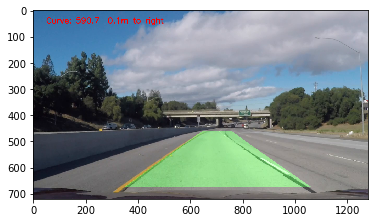

In [13]:
video = './challenge_video.mp4'
clip = VideoFileClip(video)
img = clip.get_frame(0)
#pipeline = continuous_pipeline()
#out_img = pipeline.pipeline(img)
plt.imshow(out_img)

In [15]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite('./test_images/challenge1.jpg', img)

True